# Loading the data given for the assignment

In [3]:
!wget "https://files.grouplens.org/datasets/movielens/ml-100k.zip"

--2023-12-03 14:12:35--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  11.2MB/s    in 0.4s    

2023-12-03 14:12:35 (11.2 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [4]:
!unzip "ml-100k.zip"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


# Import needed for the notebook

In [313]:
# Operationsal
import os 

# Data manipulation
import numpy as np
import pandas as pd

# Surprise lib
## Model
from surprise import SVD
## Loading the data
from surprise import Reader, Dataset
## Splitting the data
from surprise.model_selection import train_test_split
## Calculating the metrics
from surprise import accuracy
## Saving the model
from surprise import dump

# Visualizations
import matplotlib.pyplot as plt

# Manual Seeding

In [314]:
# Manual seeding
np.random.seed(42)

# Data reading and preparing

In [216]:
data = pd.read_csv("ml-100k/u.data", header=None, sep='\t',
                   names=["user_id", "movie_id", "rating", "time"])
data

,user_id,movie_id,rating,time
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [217]:
# Movies
mov = pd.read_csv("ml-100k/u.item", header=None, sep='|',  encoding='latin-1',
                  names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDB_URL'], usecols=range(5))

In [218]:
data = data.merge(mov[['movie_id', 'movie_title']], on='movie_id', how='left')

In [219]:
data

,user_id,movie_id,rating,time,movie_title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)
...,...,...,...,...,...
99995,880,476,3,880175444,"First Wives Club, The (1996)"
99996,716,204,5,879795543,Back to the Future (1985)
99997,276,1090,1,874795795,Sliver (1993)
99998,13,225,2,882399156,101 Dalmatians (1996)


In [315]:
# For visual
data['data'] = pd.to_datetime(data['time'], unit='s')

# Data exploration

In [155]:
data

,user_id,movie_id,rating,time,movie_title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)
...,...,...,...,...,...
99995,880,476,3,880175444,"First Wives Club, The (1996)"
99996,716,204,5,879795543,Back to the Future (1985)
99997,276,1090,1,874795795,Sliver (1993)
99998,13,225,2,882399156,101 Dalmatians (1996)


# Visualization for the understanding

### Movies with a lot of rates
Just to check

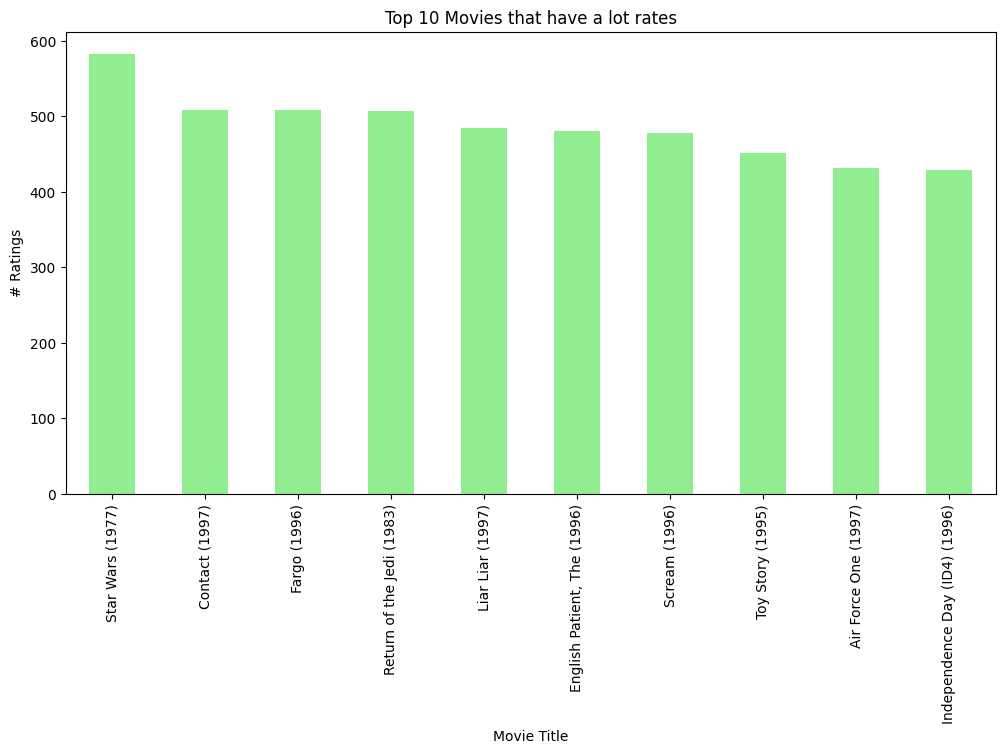

In [168]:
movies_with_a_lot_rates = data.groupby('movie_title')['user_id'].count().sort_values(ascending=False).head(10)


plt.figure(figsize=(12, 6))
movies_with_a_lot_rates.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Movies that have a lot rates')
plt.xlabel('Movie Title')
plt.ylabel('# Ratings')
plt.savefig('Top 10 Movies that have a lot rates.png')
plt.show()


### Ratings per User
To see how differs the number of ratings user makes

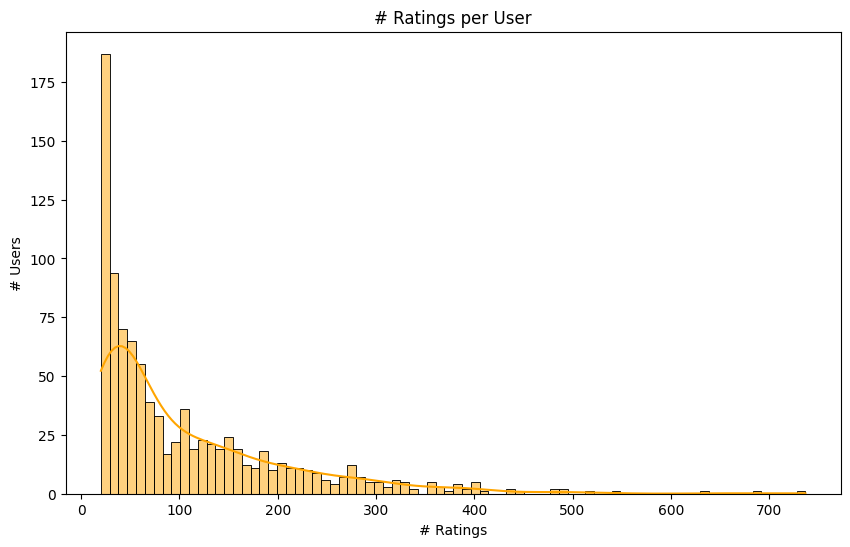

In [177]:
rpu = data.groupby('user_id')['rating'].count()

plt.figure(figsize=(10, 6))
sns.histplot(rpu, bins=80, kde=True, color='orange')
plt.title('# Ratings per User')
plt.xlabel('# Ratings')
plt.ylabel('# Users')
plt.savefig('# Ratings per User.png')
plt.show()

### Distribution of mean ratings
Here we can see that with a lot of approximation this distributino is about normal one

So we there is no so bad films exept several with lowest rates
They are a noise but for now it is okay to save them, becuase it is only 70 out of 1682

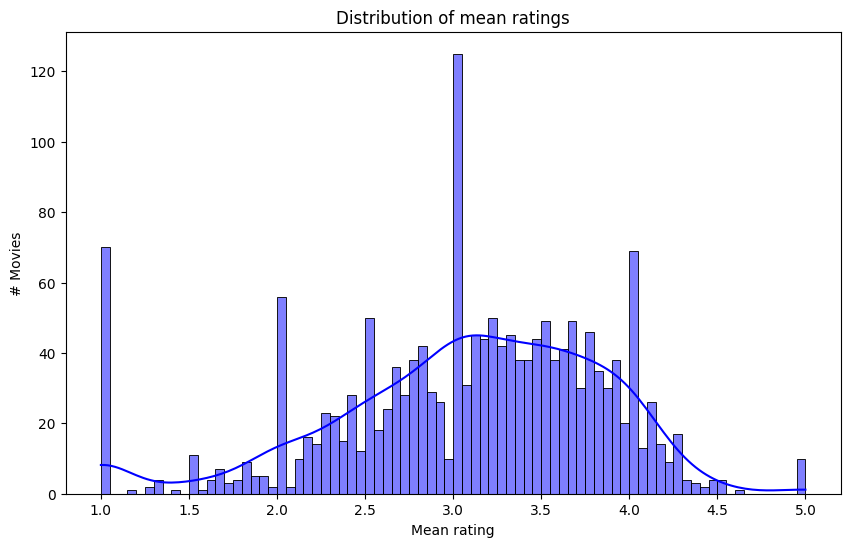

In [240]:

mean_rating = data.groupby('movie_id', as_index=False)['rating'].mean().sort_values('rating')

plt.figure(figsize=(10, 6))
sns.histplot(x=mean_rating['rating'], bins=80, kde=True, color='blue')
plt.title('Distribution of mean ratings')
plt.xlabel('Mean rating')
plt.ylabel('# Movies')
plt.savefig('Distribution of mean ratings.png')
plt.show()

### Distribution of mean ratings within users
It shows that more or less the user estimation of the films is about standart distribution
So we can use it from user perspective to find finms for the user (even without the metadata for the user) 

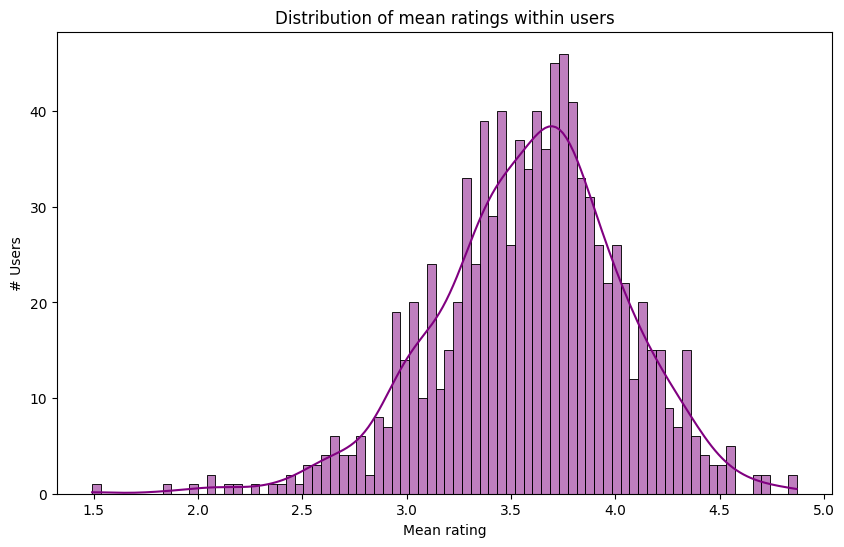

In [255]:
user_rating = data.groupby('user_id')['rating'].mean()#.sort_values('rating')

plt.figure(figsize=(10, 6))
sns.histplot(user_rating, bins=80, kde=True, color='purple')
plt.title('Distribution of mean ratings within users')
plt.xlabel('Mean rating')
plt.ylabel('# Users')
plt.savefig('Mean rate of a use on a platform.png')
plt.show()